# Resturant Food Safety Inspection Prediction Using Natual Language Processing

references:
https://dev.socrata.com/foundry/data.cityofchicago.org/4ijn-s7e5

## Summary
1. [Objective](#objective)
2. [Understanding the Data](#data)\
    2.1 [Dataset Definitions](#dataset)\
    2.2 [Observations](#observations)\
    2.3 [Feature Engineering](#engineering)
4. [Model Building](#model)\
    4.1 [Model Overview](#modeloverview)
5. [Interpretation of Results](#interpretation)
6. [References](#references)



# 1. Objective
<a id='objective'></a>

The goal of this notebook is to build a multinomial classification model to predict the outcome of the food safety inspection reports based on the inspectors' comments. I will use from statistical analysis and natural language processing to accomplish this. I will also present the results of the classification model and suggest ways that it could be improved through further analysis.

Data provided by the City of Chicago via https://data.cityofchicago.org/ https://data.cityofchicago.org/Health-Human-Services/Food-Inspections/4ijn-s7e5 as of early 2020

In [52]:
import sklearn

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import re
import itertools
import os
import random
from datetime import datetime


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn import metrics

import nltk as nltk
import nltk.corpus  
from nltk.text import Text

import sys

pd.options.display.max_rows = 999
pd.options.display.max_colwidth = 999
pd.options.mode.chained_assignment = None  # default='warn'


<a id='data'> </a>
# 2. Understanding the Data


<a id='dataset'> </a>
## 2.1 Preliminary Data Cleaning

In [2]:
#load the data
#df = pd.read_csv('../Food_Inspections.csv') #dataframe for modeling
#df_clean = df.copy() #cleaned dataframe for miscellaneous
#df_viz = df.copy() #dataframe for data viz exports for tableau


In [3]:
#!/usr/bin/env python

# make sure to install these packages before running:
# pip install pandas
# pip install sodapy

import pandas as pd
from sodapy import Socrata

# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
#client = Socrata("data.cityofchicago.org", None)

# Example authenticated client (needed for non-public datasets):
MyAppToken = 'KoNWmjvpkvV18BmVoGFCU1oCw'

client = Socrata("data.cityofchicago.org",
                  MyAppToken)
#                  userame="user@example.com",
 #                 password="AFakePassword")

# First 2000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
results = client.get("4ijn-s7e5", limit=250000)

# Convert to pandas DataFrame
results_df = pd.DataFrame.from_records(results)

In [4]:
results_df.shape

(212022, 22)

In [5]:
results_df.columns

Index(['inspection_id', 'dba_name', 'aka_name', 'license_', 'facility_type',
       'risk', 'address', 'city', 'state', 'zip', 'inspection_date',
       'inspection_type', 'results', 'violations', 'latitude', 'longitude',
       'location', ':@computed_region_awaf_s7ux',
       ':@computed_region_6mkv_f3dw', ':@computed_region_vrxf_vc4k',
       ':@computed_region_bdys_3d7i', ':@computed_region_43wa_7qmu'],
      dtype='object')

In [6]:
#drop extra columns from import
df = results_df.drop([':@computed_region_awaf_s7ux',
                 ':@computed_region_6mkv_f3dw',
                 ':@computed_region_vrxf_vc4k',
                 ':@computed_region_bdys_3d7i',
                 ':@computed_region_43wa_7qmu'], axis=1)

In [7]:
df.dtypes

inspection_id      object
dba_name           object
aka_name           object
license_           object
facility_type      object
risk               object
address            object
city               object
state              object
zip                object
inspection_date    object
inspection_type    object
results            object
violations         object
latitude           object
longitude          object
location           object
dtype: object

In [8]:
print(df.shape)
df.info()

(212022, 17)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212022 entries, 0 to 212021
Data columns (total 17 columns):
inspection_id      212022 non-null object
dba_name           212022 non-null object
aka_name           209540 non-null object
license_           212005 non-null object
facility_type      207142 non-null object
risk               211950 non-null object
address            212022 non-null object
city               211868 non-null object
state              211974 non-null object
zip                211970 non-null object
inspection_date    212022 non-null object
inspection_type    212021 non-null object
results            212022 non-null object
violations         155625 non-null object
latitude           504 non-null object
longitude          504 non-null object
location           504 non-null object
dtypes: object(17)
memory usage: 27.5+ MB


In [9]:
df.isna().sum()

inspection_id           0
dba_name                0
aka_name             2482
license_               17
facility_type        4880
risk                   72
address                 0
city                  154
state                  48
zip                    52
inspection_date         0
inspection_type         1
results                 0
violations          56397
latitude           211518
longitude          211518
location           211518
dtype: int64

It appears that we have some incorrect data types and also some missing data. I'll inspect the data column by column

**inspection_id**

In [10]:
df['inspection_id'].isna().sum()

0

In [11]:
df['inspection_id'].sample(n=5)

211138      63234
92494     1609612
118625    1497810
140910    1188728
98021     1516578
Name: inspection_id, dtype: object

**dba_name**

In [12]:
df['dba_name'].isna().sum()

0

In [13]:
df['dba_name'].sample(n=5)

171163                  CONTE'S PIZZA
57930     HYDERABAD KABAB CORNER INC.
74811                   SLICE FACTORY
177877         STUART G. FERST SCHOOL
196300      NEA AGORA PACKING COMPANY
Name: dba_name, dtype: object

**aka_name**

In [14]:
df['aka_name'].isna().sum()

2482

In [15]:
#sample of the missing aka_name values
df[df['aka_name'].isna()][['inspection_id','dba_name','aka_name']]

,inspection_id,dba_name,aka_name
41,2453694,CENTERS FOR NEW HORIZONS,NaN
82,2453552,CLAMP DOWN BURGERS,NaN
287,2453268,CENTERS FOR NEW HORIZONS,NaN
786,2401721,BABAS STEAK AND LEMONADE,NaN
896,2401643,HEALTH FOOD & GROCERIES,NaN
...,...,...,...
211938,68254,"Eastside Soccer Dome, Inc.",NaN
211944,78240,OBAMA FOOD MART,NaN
211958,158243,DUNKIN DONUTS,NaN
211979,78239,Yahs Cuisine,NaN


In [16]:
#fill NaN values with dba_name value
df['aka_name'] = df['aka_name'].fillna(df['dba_name'])

**license_**

In [17]:
df['license_'].isna().sum()

17

In [18]:
#Mostly churches...
df[df['license_'].isna()]['dba_name']

23463              ST. DEMETRIOS GREEK ORTHODOX CHURCH
40003              ST. DEMETRIOS GREEK ORTHODOX CHURCH
56994              ST. DEMETRIOS GREEK ORTHODOX CHURCH
82504              ST. DEMETRIOS GREEK ORTHODOX CHURCH
102429             ST. DEMETRIOS GREEK ORTHODOX CHURCH
127779             ST. DEMETRIOS GREEK ORTHODOX CHURCH
130312                                 ARGENTINA FOODS
145090             ST. DEMETRIOS GREEK ORTHODOX CHURCH
164723             ST. DEMETRIOS GREEK ORTHODOX CHURCH
168153                        OLD ST. PATRICK'S CHURCH
171495                 GOD'S BATTLE AXE PRAYER ACADEMY
171730                 GOD'S BATTLE AXE PRAYER ACADEMY
173251                 GOD'S BATTLE AXE PRAYER ACADEMY
182444             ST. DEMETRIOS GREEK ORTHODOX CHURCH
193595    AVALON COMMUNITY CHURCH/FREEDOM HOME ACADEMY
201797                             ST DEMETRIOS CHURCH
204380                        OLD ST. PATRICK'S CHURCH
Name: dba_name, dtype: object

In [19]:
#fill with "Not Disclosed"
df['license_'] = df['license_'].fillna('Not Disclosed')

**facility_type**

In [20]:
df['facility_type'].isna().sum()

4880

In [21]:
df[df['facility_type'].isna()]['dba_name'].value_counts().head(20)

SUBWAY                          34
DUNKIN DONUTS                   20
WHITE HEN PANTRY                18
7-ELEVEN                        18
HAROLD'S CHICKEN SHACK          15
TOKYO LUNCH BOXES & CATERING    13
KENTUCKY FRIED CHICKEN          12
MIDWEST BUDDHIST TEMPLE         11
MCDONALD'S                      10
MCDONALDS                        8
HEAVEN'S LEARNING GARDEN         7
SCHLENKO INC.                    7
GOLD COAST DOGS                  6
COLD STONE CREAMERY              6
THUNDERBIRD CATERING             6
DEOLA'S                          5
CALIFORNIA FOODS                 5
MAN-O-SALWA                      5
QUIZNOS                          5
BELEN                            5
Name: dba_name, dtype: int64

In [22]:
df[df['facility_type'].isna()]['dba_name'].value_counts().describe()

count    4108.000000
mean        1.187926
std         0.949276
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        34.000000
Name: dba_name, dtype: float64

In [23]:
df['facility_type'].value_counts().head(15)

Restaurant                         141072
Grocery Store                       27738
School                              13076
Children's Services Facility         3574
Bakery                               3095
Daycare (2 - 6 Years)                2793
Daycare Above and Under 2 Years      2580
Long Term Care                       1426
Catering                             1278
Liquor                                931
Mobile Food Dispenser                 883
Daycare Combo 1586                    741
Mobile Food Preparer                  673
Golden Diner                          599
Hospital                              592
Name: facility_type, dtype: int64

It's not clear why so many of these facility types are missing. Some of the businesses are obvious (7-Eleven, Quiznos, for instance) but many aren't... For now, I'll fill the NA values with not disclosed


In [24]:
df['facility_type'] = df['facility_type'].fillna('Not Disclosed')

**risk**

In [25]:
df['risk'].value_counts()

Risk 1 (High)      151563
Risk 2 (Medium)     41384
Risk 3 (Low)        18972
All                    31
Name: risk, dtype: int64

In [26]:
df['risk'].isna().sum()

72

In [27]:
df[df['risk'].isna()].sample(n=5, random_state=512)

,inspection_id,dba_name,aka_name,license_,facility_type,risk,address,city,state,zip,inspection_date,inspection_type,results,violations,latitude,longitude,location
65104,2009375,"CHICAGO BEST DELI GROCERY,INC","CHICAGO BEST DELI GROCERY,INC",2512074,Not Disclosed,NaN,156-158 W 95TH ST,CHICAGO,IL,60628,2017-03-28T00:00:00.000,License,Not Ready,NaN,NaN,NaN,NaN
181092,537572,unknown,unknown,0,Not Disclosed,NaN,10222 S wentworth AVE,CHICAGO,IL,60628,2011-09-07T00:00:00.000,Complaint-Fire,Business Not Located,NaN,NaN,NaN,NaN
34956,2229372,RICE THAI CAFE,RICE THAI CAFE,2589016,Not Disclosed,NaN,211`7 W FARRAGUT AVE,CHICAGO,IL,60625,2018-10-04T00:00:00.000,License,Business Not Located,NaN,NaN,NaN,NaN
196602,428391,BEST SUBS,BEST SUBS,0,Not Disclosed,NaN,2653 N WASTENAW AVE BLDG,CHICAGO,IL,60647,2010-10-29T00:00:00.000,Complaint,Business Not Located,NaN,NaN,NaN,NaN
25352,2286042,REIS AND IRVYS,REIS AND IRVYS,2659028,Not Disclosed,NaN,1801 W JACKSON BLVD,CHICAGO,IL,60612,2019-04-30T00:00:00.000,License,Not Ready,NaN,NaN,NaN,NaN


Notice that many of the missing risk values are records that were also missing other attributes...


In [28]:
#I'll fill missing risk values with not disclosed
df['risk'] = df['risk'].fillna('Not Disclosed')

**address**

In [29]:
df['address'].isna().sum()

0

In [30]:
df['address'].value_counts().head(10)

11601 W TOUHY AVE             2674
5700 S CICERO AVE              583
500 W MADISON ST               462
2300 S THROOP ST               405
324 N LEAVITT ST               391
131 N CLINTON ST               353
100 W RANDOLPH ST              331
222 W MERCHANDISE MART PLZ     279
600 E GRAND AVE                276
7601 S CICERO AVE              267
Name: address, dtype: int64

Some of these make sense:

* 5700 S CICERO AVE = Chicago Midway
* 500 W MADISON ST = Accenture Tower


**city**

In [31]:
df['city'].isna().sum()

154

In [32]:
df['city'].sample(n=5)

18328     CHICAGO
2237      CHICAGO
157073    CHICAGO
188679    CHICAGO
20640     CHICAGO
Name: city, dtype: object

In [33]:
df['city'] = df['city'].fillna('Not Disclosed')
df['city'] = df['city'].str.upper()

In [34]:
df['city'].value_counts().head(30)

CHICAGO              211598
NOT DISCLOSED           154
CCHICAGO                 48
SCHAUMBURG               27
MAYWOOD                  16
ELK GROVE VILLAGE        13
EVANSTON                 11
CICERO                    9
CHICAGOCHICAGO            9
INACTIVE                  8
SKOKIE                    8
NILES NILES               7
ELMHURST                  7
CHCHICAGO                 6
CALUMET CITY              6
WORTH                     5
OAK PARK                  5
ALSIP                     4
SUMMIT                    4
CHARLES A HAYES           4
BRIDGEVIEW                4
EAST HAZEL CREST          3
PLAINFIELD                3
SCHILLER PARK             3
CHICAGOHICAGO             3
ROSEMONT                  3
CHCICAGO                  3
CHICAGOI                  3
312CHICAGO                3
CHICAGO.                  2
Name: city, dtype: int64

In [35]:
df['city'] = df['city'].replace('chicago','CHICAGO')
df['city'] = df['city'].replace('Chicago','CHICAGO')
df['city'] = df['city'].replace('CCHICAGO','CHICAGO')
df['city'] = df['city'].replace('CHICAGOCHICAGO','CHICAGO')
df['city'] = df['city'].replace('CHCHICAGO','CHICAGO')
df['city'] = df['city'].replace('CHICAGOHICAGO','CHICAGO')
df['city'] = df['city'].replace('CHICAGO.','CHICAGO')
df['city'] = df['city'].replace('312CHICAGO','CHICAGO')
df['city'] = df['city'].replace('CHicago','CHICAGO')
df['city'] = df['city'].replace('CHICAGOI','CHICAGO')
df['city'] = df['city'].replace('CHCICAGO','CHICAGO')
#df['city'] = df['city'].replace('','CHICAGO')


**state**

In [36]:
df['state'].isna().sum()

48

In [37]:
df[df['state'].isna()][['dba_name','city','state']].head(10)

,dba_name,city,state
5631,CRATER FOOD & LIQUOR,CHICAGO,NaN
6187,YOLK - LINCOLN PARK,CHICAGO,NaN
6191,CRATER FOOD & LIQUOR,CHICAGO,NaN
6218,Starbucks Coffee#51211,NOT DISCLOSED,NaN
6684,STAX CAFE,CHICAGO,NaN
7067,WINGSTOP,CHICAGO,NaN
19160,"AMY BECK CAKE DESIGN, LLC",NOT DISCLOSED,NaN
23198,STAX CAFE,CHICAGO,NaN
23616,CITY HALL. LLC,CHICAGO,NaN
23618,CITY HALL. LLC,CHICAGO,NaN


It appears there is a data input problem. For now, I'll manually fill missing states


In [38]:
df.loc[(df.city=='CHICAGO')&(df.state.isna()),'state'] = 'IL'

In [39]:
df['state'] = df['state'].fillna('Not Disclosed')

In [40]:
df['state'].value_counts()

IL               211999
Not Disclosed        20
WI                    1
NY                    1
IN                    1
Name: state, dtype: int64

Not sure why there are other states in this dataset. For now, I'll drop other states.

In [41]:
index_list = df[df.state != 'IL'].index.to_list()

df = df.drop(index_list)

**zip**

In [42]:
df['zip'].isna().sum()

52

There are only 52 observations with missing zip values so I'll drop these values


In [43]:
df = df.dropna(subset=['zip'])

**inspection_date**

In [53]:
df['inspection_date'].isna().sum()

0

In [54]:
print(df['inspection_date'][5])
type(df['inspection_date'].iloc[5])

2020-10-23T00:00:00.000


str

I'll need to conver the inspection date column to datetime

In [55]:
#Convert inspection_date column
df['inspection_date_new'] = df['inspection_date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%S.%f'))


In [56]:
df.iloc[0]['inspection_date_new'].strftime(format='%x')

'10/26/20'

In [57]:
print(df['inspection_date_new'][5])
type(df['inspection_date_new'].iloc[5])


2020-10-23 00:00:00


pandas._libs.tslibs.timestamps.Timestamp

In [58]:
df['inspection_date_new'] = df['inspection_date_new'].apply(lambda x: x.strftime(format='%x'))

In [59]:
print(df['inspection_date_new'][5])
type(df['inspection_date_new'].iloc[5])

10/23/20


str

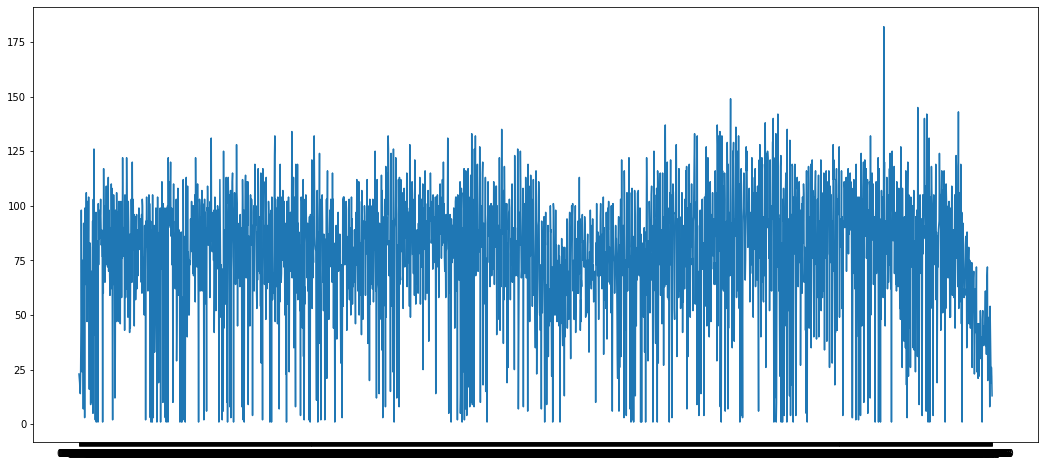

In [60]:
import matplotlib.pylab as plt
from collections import Counter

# Tally occurrences of words in a list
cnt = Counter()
for day in df['inspection_date_new']:
    cnt[day] += 1


lists = sorted(cnt.items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.figure(figsize=(18,8))
plt.plot(x, y)

plt.show()


**inspection_type**


In [61]:
df['inspection_type'].isna().sum()


1

In [62]:
df = df.dropna(subset=['inspection_type'])


In [63]:
df['inspection_type'].value_counts().head(15)


Canvass                                   112771
License                                    27804
Canvass Re-Inspection                      22533
Complaint                                  19616
License Re-Inspection                       9471
Complaint Re-Inspection                     8096
Short Form Complaint                        7135
Suspected Food Poisoning                     874
Consultation                                 672
License-Task Force                           604
Tag Removal                                  603
Recent Inspection                            357
Out of Business                              284
Task Force Liquor 1475                       252
Suspected Food Poisoning Re-inspection       193
Name: inspection_type, dtype: int64

**results**


In [64]:
pd.DataFrame({'counts':df['results'].value_counts(),
              'percentage':df['results'].value_counts()/df.shape[0]})

,counts,percentage
Pass,111257,0.524931
Fail,40971,0.193309
Pass w/ Conditions,32001,0.150987
Out of Business,18389,0.086763
No Entry,7059,0.033306
Not Ready,2199,0.010375
Business Not Located,70,0.000330


I'm building a classification model to predict the multinomial classifications above based on the inspector's comments. Therefore, I plan to exclude the four results that we do not have sufficient records. Separately, I also noticed some records for "no entry" still had comments associated with them. 

In [65]:
df[df['results']=='No Entry']

,inspection_id,dba_name,aka_name,license_,facility_type,risk,address,city,state,zip,inspection_date,inspection_type,results,violations,latitude,longitude,location,inspection_date_new
6,2453751,EL POTRILLO,EL POTRILLO,13419,Liquor,Risk 3 (Low),5129 S ARCHER AVE,CHICAGO,IL,60632,2020-10-23T00:00:00.000,Complaint Re-Inspection,No Entry,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL EMPLOYEE; KNOWLEDGE, RESPONSIBILITIES AND REPORTING - Comments: 2-102.14(O): NO EMPLOYEE HEALTH POLICY ON SITE. INSTD TO PROVIDE A VERFIABLE EMPLOYEE HEALTH POLICY AND MAINTAIN. PRIORITY FOUNDATION 7-38-010 | 5. PROCEDURES FOR RESPONDING TO VOMITING AND DIARRHEAL EVENTS - Comments: 2-501.11: NO PROCEDURE IN PLACE FOR VOMITING AND DIARRHEAL EVENTS. INSTD TO PROVIDE PROCEDURE AND NECESSARY SUPPLIES EFFECTIVE AGAINST NOROVIRUS. PRIORITY FOUNDATION 7-38-005 | 10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLIED AND ACCESSIBLE - Comments: 5-204.11: NO HANDWASH SINK IN BAR AREA. INSTD TO PROVIDE A HANDWASH SINK PROPERLY CONNECTED UNDER CITY PRESSURE WITH 100F-120F TEMPERATURE OF WATER. PRIORITY FOUNDATION 7-38-030(C) | 38. INSECTS, RODENTS, & ANIMALS NOT PRESENT - Comments: 6-501.111: 3 LIVE ROACHES AND ROACH FECES NOTED AT BAR 3-COMPARTMENT SINK. INSTD TO REMOVE ROACHES AND FECES, CLEAN AND SANITIZED AFFECTED AREAS. CITATION ISSUED PRIORITY FO...",NaN,NaN,NaN,10/23/20
33,2453716,GOURMET GORILLA,HUNTER PERKINS CAMPUS,2608552,CHARTER SCHOOL,Risk 1 (High),1700 W 83RD ST,CHICAGO,IL,60620,2020-10-22T00:00:00.000,Canvass,No Entry,NaN,NaN,NaN,NaN,10/22/20
68,2453641,SANJUSTIN'S KITCHEN INC.,SANJUSTIN'S KITCHEN,2418532,Catering,Risk 1 (High),157 W 75th ST,CHICAGO,IL,60620,2020-10-21T00:00:00.000,Canvass,No Entry,58. ALLERGEN TRAINING AS REQUIRED - Comments: Violation Codes: 2-102.13 Inspector Comments: NO ALLERGEN TRAINING FOR THE CERTIFIED FOOD MANAGERS. INSTRUCTED THAT ANY EMPLOYEE WITH CITY OF CHICAGO FOOD CERTIFICATE MUST HAVE ALLERGEN TRAINING.,NaN,NaN,NaN,10/21/20
69,2453650,STUDIO MOVIE GRILL,STUDIO MOVIE GRILL,2309244,Restaurant,Risk 1 (High),210 W 87TH ST,CHICAGO,IL,60620,2020-10-21T00:00:00.000,Canvass,No Entry,"55. PHYSICAL FACILITIES INSTALLED, MAINTAINED & CLEAN - Comments: Violation Codes: 6-501.11 Inspector Comments: DAMAGED FLOOR TILE AROUND THE FLOOR DRAIN BEHIND THE CONCESSION STAND. INSTRUCTED TO REPAIR/REPLACE FLOOR TILE. MAINTAIN SMOOTH AND EASILY CLEANABLE FLOORS. | 58. ALLERGEN TRAINING AS REQUIRED - Comments: Violation Codes: 2-102.13 Inspector Comments: OBSERVED NO ALLERGEN TRAINING AVAILABLE DURING INSPECTION. ALL CERTIFIED MANAGERS MUST PROVIDE ALLERGEN TRAINING.",NaN,NaN,NaN,10/21/20
70,2453659,WALMART #5781,WALMART #5781,2104019,Grocery Store,Risk 1 (High),8331 S STEWART AVE,CHICAGO,IL,60620,2020-10-21T00:00:00.000,Canvass,No Entry,49. NON-FOOD/FOOD CONTACT SURFACES CLEAN - Comments: Violation Codes: 4-602.13 Inspector Comments: FOUND BLACK MOLD LIKE SUBSTANCE ON THE STORAGE RACKS WHERE THE JUICES ARE STORED IN THE REAR COLD HOLDING UNIT. INSTRUCTED TO KEEP RACKS CLEAN.,NaN,NaN,NaN,10/21/20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167320,1230048,TAPAS LAS RAMBLAS,TAPAS LAS RAMBLAS,1799141,Restaurant,Risk 1 (High),5101-5103 N CLARK ST,CHICAGO,IL,60640,2012-06-05T00:00:00.000,Complaint,No Entry,NaN,NaN,NaN,NaN,06/05/12
167748,1229216,KATSU ENTERPRISESES INC,KATSU JAPANESE RESTAURANT,16281,Restaurant,Risk 1 (High),2651 W PETERSON AVE,CHICAGO,IL,60659,2012-05-29T00:00:00.000,Canvass,No Entry,NaN,NaN,NaN,NaN,05/29/12
167761,1229215,CHICAGO FONDUE STUBE,CHICAGO FONDUE STUBE,26813,Restaurant,Risk 1 (High),2717 W PETERSON AVE,CHICAGO,IL,60659,2012-05-29T00:00:00.000,Canvass,No Entry,NaN,NaN,NaN,NaN,05/29/12
172349,671042,MAGNOLIA CAFE,MAGNOLIA CAFE,1968899,Restaurant,Risk 1 (High),1224 W WILSON AVE,CHICAGO,IL,60640,2012-03-01T00:00:00.000,Canvass,No Entry,NaN,NaN,NaN,NaN,03/01/12


In [66]:
#I'm setting the threshold for data sufficiency at 15%, so if a result is not at least 15% of the dataset, it will be dropped
perc = df['results'].value_counts()/df.shape[0]
my_list = perc[perc>0.15].keys().to_list()
print(my_list)

df = df[df.results.isin(my_list)]

['Pass', 'Fail', 'Pass w/ Conditions']


**violations**


In [67]:
df.violations.isna().sum()

29228

In [68]:
df[df['violations'].isna()].sample(n=10, random_state=512)

,inspection_id,dba_name,aka_name,license_,facility_type,risk,address,city,state,zip,inspection_date,inspection_type,results,violations,latitude,longitude,location,inspection_date_new
210015,197273,DUNKIN DONUTS,DUNKIN DONUTS / BASKIN & ROBBINS,2020849,Restaurant,Risk 2 (Medium),6 N WABASH AVE,CHICAGO,IL,60602,2010-02-17T00:00:00.000,License,Pass,NaN,NaN,NaN,NaN,02/17/10
198265,401248,65 ASIAN KITCHKEN,65 ASIAN KITCHKEN,1474110,Restaurant,Risk 1 (High),111 W JACKSON BLVD,CHICAGO,IL,60604,2010-10-01T00:00:00.000,Canvass Re-Inspection,Pass,NaN,NaN,NaN,NaN,10/01/10
153037,1110303,NORTHWESTERN MEMORIAL HOSPITAL (CAFETERIA-2ND),CAFE 251,10393,Restaurant,Risk 1 (High),251 E HURON ST,CHICAGO,IL,60611,2013-03-06T00:00:00.000,Canvass Re-Inspection,Pass,NaN,NaN,NaN,NaN,03/06/13
177297,569700,HEAVEN ON SEVEN ON RUSH,HEAVEN ON SEVEN ON RUSH,54289,Restaurant,Risk 1 (High),600 N MICHIGAN AVE,CHICAGO,IL,60611,2011-11-16T00:00:00.000,Canvass Re-Inspection,Pass,NaN,NaN,NaN,NaN,11/16/11
198944,401219,HAROLD'S CHICKEN SHACK,HAROLD'S CHICKEN SHACK,30085,Restaurant,Risk 2 (Medium),636 S WABASH AVE,CHICAGO,IL,60605,2010-09-21T00:00:00.000,Complaint Re-Inspection,Pass,NaN,NaN,NaN,NaN,09/21/10
190167,569251,FOX & OBEL,FOX & OBEL,1893331,Restaurant,Risk 1 (High),401 E ILLINOIS ST,CHICAGO,IL,60611,2011-03-21T00:00:00.000,Complaint Re-Inspection,Pass,NaN,NaN,NaN,NaN,03/21/11
63385,2049240,HOTEL EMC2,HOTEL EMC2,2496530,Restaurant,Risk 1 (High),228 E ONTARIO ST,CHICAGO,IL,60611,2017-04-25T00:00:00.000,License,Pass,NaN,NaN,NaN,NaN,04/25/17
19715,2304586,ROOTS HANDMADE PIZZA - SECOND CITY/UTOPIAN TAILGAT,ROOTS HANDMADE PIZZA - SECOND CITY/UTOPIAN TAILGAT,2636845,Restaurant,Risk 3 (Low),1610 N WELLS ST,CHICAGO,IL,60614,2019-08-13T00:00:00.000,License,Fail,NaN,NaN,NaN,NaN,08/13/19
103323,1561255,BRONZEVILLE MARKET PLACE INC,BRONZEVILLE MARKET PLACE,2412417,Grocery Store,Risk 2 (Medium),450 E 43RD ST,CHICAGO,IL,60653,2015-07-15T00:00:00.000,License,Pass,NaN,NaN,NaN,NaN,07/15/15
66269,1995332,CHINA CHEF,CHINA CHEF,2245705,Restaurant,Risk 1 (High),4600 W BELMONT AVE,CHICAGO,IL,60641,2017-03-09T00:00:00.000,Complaint Re-Inspection,Pass,NaN,NaN,NaN,NaN,03/09/17


The inspector's comments are a key independent variable. Therefore, any records with missing comments have to be dropped

In [69]:
df = df.dropna(subset=['violations'])

**latitude & longitude, and location**

In [70]:
print('lat:',df.latitude.isna().sum())
print('long:',df.longitude.isna().sum())
print('location:',df['location'].isna().sum())

lat: 154716
long: 154716
location: 154716


In [71]:
df['latitude'] = df['latitude'].fillna('Not Disclosed')
df['longitude'] = df['longitude'].fillna('Not Disclosed')
df['location'] = df['location'].fillna('Not Disclosed')


I want to use the address and the geopy package to pull the latitude and longitude values. But I noticed there were a lot of typos in the City list. We know that a city can have multiple zipcodes but a zipcode can only have one city.

## sample geopy code

In [72]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="test")
location = geolocator.geocode("121 N LaSalle St, Chicago, IL 60602")
print(location.address)
print((location.latitude, location.longitude))
print(location.raw)


121, North LaSalle Street, Loop, Chicago, Cook County, Illinois, 60602, United States of America
(41.88341706625744, -87.632303164487)
{'place_id': 248024928, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright', 'osm_type': 'way', 'osm_id': 435704691, 'boundingbox': ['41.883367066257', '41.883467066257', '-87.632353164487', '-87.632253164487'], 'lat': '41.88341706625744', 'lon': '-87.632303164487', 'display_name': '121, North LaSalle Street, Loop, Chicago, Cook County, Illinois, 60602, United States of America', 'class': 'place', 'type': 'house', 'importance': 0.731}


Shape of the dataset

In [73]:
df.shape

(155001, 18)

# Data Dictionary

**Inspection ID:** unqiue identifier

**DBA Name:** "doing businessness as"

**AKA Name:** "also known as"

**License #:** License Number identification

**Facility Type:** The type of facility. Examples include: restaurant, grocery store, school, bakery, catering, etc.

**Risk:** Risk category. Categorical value of risk 1, risk 2, risk 3, or "all".

**Address:** Number and street name. For example, 401 N WABASH AVE

**City:** Self explanatory

**State:** Self explanatory

**Zip:** Self explanatory

**Inspection Date:**

**Inspection Type:** 

**Results:** Categorical value: Pass, Fail, Pass w/ Conditions, Out of Business, No Entry, Not Ready, Business Not Located

**Violations:** String of specific code violation and inspector's comments.

**Latitude:** Self explanatory

**Longitude:** Self explanatory

**Location:** Comination of latitude and longitude columns

<a id='observations'></a>
### 2.1 Observations

Two analyses: descriptive analysis and predictive modeling. For the predictive modeling, we only care about the 'results' and 'violations' columns



In [74]:
#Ten most popular facility types
df['facility_type'].value_counts()[:15]

Restaurant                         106066
Grocery Store                       19972
School                              11412
Children's Services Facility         2704
Bakery                               2326
Daycare Above and Under 2 Years      1984
Daycare (2 - 6 Years)                1937
Long Term Care                       1217
Catering                              856
Liquor                                513
Daycare Combo 1586                    491
Golden Diner                          455
Mobile Food Preparer                  412
Hospital                              404
Wholesale                             315
Name: facility_type, dtype: int64

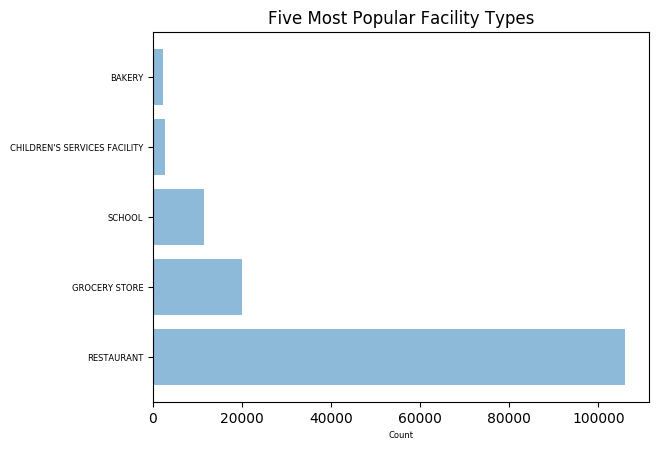

In [75]:
vc = df['facility_type'].str.upper().value_counts()[:5]


import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

objects = vc.keys()
y_pos = np.arange(len(objects))
performance = vc.values

plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects, fontsize=6)
plt.xlabel('Count', fontsize=6)
plt.title('Five Most Popular Facility Types')

plt.show()

In [76]:
df['risk'].value_counts()

Risk 1 (High)      116738
Risk 2 (Medium)     29228
Risk 3 (Low)         9033
Not Disclosed           2
Name: risk, dtype: int64

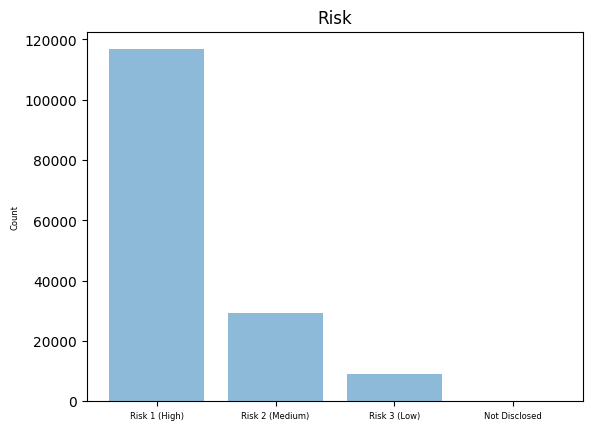

In [77]:
vc = df['risk'].value_counts()

import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

objects = vc.keys()
y_pos = np.arange(len(objects))
performance = vc.values

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects, fontsize=6)
plt.ylabel('Count', fontsize=6)
plt.title('Risk')

plt.show()

In [78]:
#sample restaurant
df[df['facility_type']=='Restaurant'].sample(n=1, random_state=777)

,inspection_id,dba_name,aka_name,license_,facility_type,risk,address,city,state,zip,inspection_date,inspection_type,results,violations,latitude,longitude,location,inspection_date_new
159565,1202486,MY MOTHER'S KITCHEN,MY MOTHER'S KITCHEN,2120593,Restaurant,Risk 1 (High),6818 W NORTH AVE,CHICAGO,IL,60707,2012-10-25T00:00:00.000,Canvass,Pass,"33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSILS CLEAN, FREE OF ABRASIVE DETERGENTS - Comments: CLEAN THE FRYERS AND THE CABINETS BELOW AND THE FILTERS ABOVE HAS GREASE BUILDUP ON THEM. | 34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOOD REPAIR, COVING INSTALLED, DUST-LESS CLEANING METHODS USED - Comments: CLEAN THE BASEMENT FLOORS IN THE FURNACE ROOM ALONG THE WALLS AND IN THE CORNERS SOME DUST ON THEM. IN THE WOMENS TOILET SOME FLOOR TILES ARE LOOSE AND SOME ARE CRACKED. INSTRUCTED TO SECURE THE ONES THAT ARE LOOSE AND REPLACE THE ONES THAT ARE CRACKED.",Not Disclosed,Not Disclosed,Not Disclosed,10/25/12


Cities

In [79]:
df['city'].value_counts()[:10]

CHICAGO              154873
NOT DISCLOSED            50
SCHAUMBURG               15
ELK GROVE VILLAGE         8
EVANSTON                  7
MAYWOOD                   4
ELMHURST                  4
SKOKIE                    4
NILES NILES               4
PLAINFIELD                3
Name: city, dtype: int64

In [80]:
len(df['city'].unique())

29

Results

In [81]:
df['results'].value_counts()

Pass                  85754
Fail                  37804
Pass w/ Conditions    31443
Name: results, dtype: int64

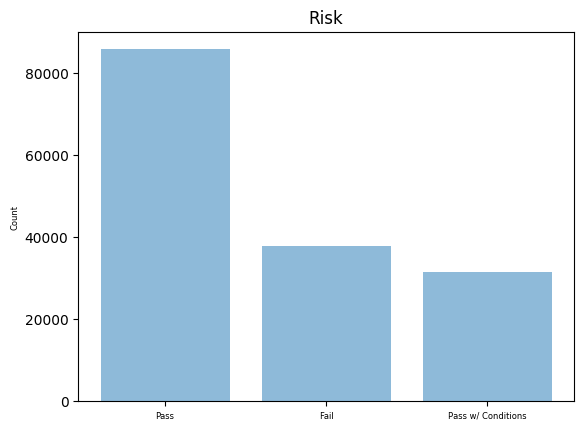

In [82]:
vc = df['results'].value_counts()

import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

objects = vc.keys()
y_pos = np.arange(len(objects))
performance = vc.values

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects, fontsize=6)
plt.ylabel('Count', fontsize=6)
plt.title('Risk')

plt.show()

In [83]:
df.columns

Index(['inspection_id', 'dba_name', 'aka_name', 'license_', 'facility_type',
       'risk', 'address', 'city', 'state', 'zip', 'inspection_date',
       'inspection_type', 'results', 'violations', 'latitude', 'longitude',
       'location', 'inspection_date_new'],
      dtype='object')

In [84]:
#Drop Unneccesary Columns
select_cols = ['results', 'violations']

#Create prediction dataframe for the prediction modeling
pred_df = df.copy()
pred_df = pred_df[select_cols]


In [85]:
pred_df.head(2)

,results,violations
0,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL EMPLOYEE; KNOWLEDGE, RESPONSIBILITIES AND REPORTING - Comments: NO EMPLOYEE HEALTH POLICY ON SITE. MUST PROVIDE WRITTEN EMPLOYEE ACKNOWLEDGED POLICY FOR ALL EMPLOYEES. PRIORITY FOUNDATION VIOLATION. 7-38-010 CITATION ISSUED | 5. PROCEDURES FOR RESPONDING TO VOMITING AND DIARRHEAL EVENTS - Comments: NO VOMIT AND DIARRHEA CLEAN UP POLICY ON SITE. MUST PROVIDE PROCEDURE FOR THE CLEAN UP OF VOMIT AND DIARRHEAL EVENTS. MUST PROVIDE CORRESPONDING EQUIPMENT OUTLINED IN THE PROCEDURE. PRIORITY FOUNDATION VIOLATION. PRIORITY FOUNDATION 7-38-005 CITATION ISSUED | 16. FOOD-CONTACT SURFACES: CLEANED & SANITIZED - Comments: UNCLEAN KNIVES IN KNIFE RACK. INSTD TO CLEAN KNIVES AND STORE ONLY CLEAN KNIVES IN KNIFE RACK | 57. ALL FOOD EMPLOYEES HAVE FOOD HANDLER TRAINING - Comments: EMPLOYEE MISSING FOOD HANDLER TRAINING. INSTD TO OBTAIN TRAINING AND MAINTAIN VERIFICATION ON SITE"
1,Fail,"47. FOOD & NON-FOOD CONTACT SURFACES CLEANABLE, PROPERLY DESIGNED, CONSTRUCTED & USED - Comments: 4-501.12: CUTTING BOARD NEXT TO 3-COMPARTMENT SINK HEAVILY STAINED AND WITH DEEP, DARK GROOVES. INSTD TO REPLACE AND MAINTAIN CUTTING BOARDS. | 53. TOILET FACILITIES: PROPERLY CONSTRUCTED, SUPPLIED, & CLEANED - Comments: 5-501.17: MISSING COVER FOR RECEPACLE IN TOILET ROOM. INSTD TO PROVIDE AND MAINTAIN | 59. PREVIOUS PRIORITY FOUNDATION VIOLATION CORRECTED - Comments: 8-404.13(B:4): **P** Enforcement by the Regulatory Authority (Non-Compliance) PREVIOUS PRIORITY FOUNDATION FROM 10/19/20 FROM REPORT 2453491 NOT CORRECTED 51 UNABLE TO LOCATE BACKFLOW DEVICE ON ICE MACHINES. INSTD TO BE ABLE TO LOCATE OR INSTALL SAME. 55 CRACKED FLOOR TILES NEAR REAR BASEMENT STAIRS. INSTD TO REPAIR TILES SO AS SURFACE TO BE SMOOTH EVEN AND EASILY CLEANABLE SURFACE. 55 REAR STAIRWELL LEADING TO BASEMENT NOT CLEAN, EXCESSIVE DEBRIS BUILD UP (STAIRS, RAILS, WALLS). INSTD TO CLEAN ALL AND MAINTAIN. ..."


In [86]:
print(pred_df.info())
print(pred_df.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 155001 entries, 0 to 212021
Data columns (total 2 columns):
results       155001 non-null object
violations    155001 non-null object
dtypes: object(2)
memory usage: 3.5+ MB
None
       results  \
count   155001   
unique       3   
top       Pass   
freq     85754   

                                                                                                                               violations  
count                                                                                                                              155001  
unique                                                                                                                             153907  
top     45. FOOD HANDLER REQUIREMENTS MET - Comments: ALL FOOD HANDLING EMPLOYEES MUST SHOW PROOF OF FOOD HANDLER TRAINING. MUST PROVIDE.  
freq                                                                                                                    

Location

<a id='engineering'></a>
## 2. Feature Engineering

Notice, the format of the violations column. The column includes the code violation number, the code description, and the inspector's comments on the specific violation. 

Sample:

"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOOD REPAIR, COVING INSTALLED, DUST-LESS CLEANING METHODS USED - Comments: POOLING WATER THROUGHOUT REAR LARGE BAR. MUST MAINTAIN DRY. MISSING FLOOR TILES AND UNEVEN FLOORING THROUGHOUT DISH AREA WITH POOLING WATER. MUST MAKE FLOORS SMOOTH AND EASILY CLEANABLE.   | 35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTRUCTED PER CODE: GOOD REPAIR, SURFACES CLEAN AND DUST-LESS CLEANING METHODS - Comments: MUST INSTALL CEILINGS IN THE NEWLY INSTALL FRONT WASHROOMS. RAW WOODEN WALL COVERING IN MENS WASHROOM. MUST PROPERLY SEAL."


* Extract only comments from violations, drop rest of text


* map Results_Flag
The results currently fall into one of three buckets. I want to map these categorical columns to specific flag values.

In [87]:
#Check sample Violation entry
pred_df['violations'].sample(n=1, random_state=512)

154243    14. PREVIOUS SERIOUS VIOLATION CORRECTED, 7-42-090 - Comments: PREVIOUS SERIOUS VIOLATIONS NOT CORRECTED PER MUNICIPAL CODE OF CHICAGO FROM REPORT #1154837 ON 1-28-13 AND #1154837 ON 2-4-13. 18-10-15 MICE DROPPINGS ON EXTENSION CORD LEADING FROM OUTLET BEHIND MICROWAVE, ABOVE CABINETS, TO OUTLET BEHIND REFRIGERATOR, 3 MICE DROPPINGS INSIDE CABINET UNDER 3-COMP SINK, 3 MICE DROPPINGS ON PLATE ON TOP OF POT FILLED WITH GREASE ON STOVE, 5 MICE DROPPINGS ON STOVE, 10-15 MICE DROPPINGS ON MUFFIN PANS, PLASTIC CONTAINERS AND MULTI-USE EQUIPMENT ON ROLLING CART IN KITCHEN, 10-15 MICE DROPPINGS ON FLOOR UNDER TABLE, BEHIND TOTES AND STORAGE BOXES IN SOUTHEAST CORNER NEAR EXIT DOOR, 5 MICE DROPPINGS ON TOY SHELVES UNDER CANVAS BAGS ALONG WEST WALL,  50-60 MICE DROPPINGS SCATTERED ON FLOOR BEHIND FRONT COUNTER ALONG WALLS BEHIND DOOR, FILE CABINETS, ETC. INSTRUCTED MANAGER TO CALL AN EXTERMINATOR FOR SERVICE, CLEAN AND SANITIZE ALL AREAS. PROVIDE RECENT PEST CONTROL LOG BOOK WITH PEST 

In [88]:
#regex expression to extract the text following "Comments:"
pred_df.violations = pred_df.violations.str.findall(r"(?:\sComments:\s.*?)?(?:[|]|$)")

In [89]:
#Now check the same sample
pred_df['violations'].sample(n=1, random_state=512)

154243    [ Comments: PREVIOUS SERIOUS VIOLATIONS NOT CORRECTED PER MUNICIPAL CODE OF CHICAGO FROM REPORT #1154837 ON 1-28-13 AND #1154837 ON 2-4-13. 18-10-15 MICE DROPPINGS ON EXTENSION CORD LEADING FROM OUTLET BEHIND MICROWAVE, ABOVE CABINETS, TO OUTLET BEHIND REFRIGERATOR, 3 MICE DROPPINGS INSIDE CABINET UNDER 3-COMP SINK, 3 MICE DROPPINGS ON PLATE ON TOP OF POT FILLED WITH GREASE ON STOVE, 5 MICE DROPPINGS ON STOVE, 10-15 MICE DROPPINGS ON MUFFIN PANS, PLASTIC CONTAINERS AND MULTI-USE EQUIPMENT ON ROLLING CART IN KITCHEN, 10-15 MICE DROPPINGS ON FLOOR UNDER TABLE, BEHIND TOTES AND STORAGE BOXES IN SOUTHEAST CORNER NEAR EXIT DOOR, 5 MICE DROPPINGS ON TOY SHELVES UNDER CANVAS BAGS ALONG WEST WALL,  50-60 MICE DROPPINGS SCATTERED ON FLOOR BEHIND FRONT COUNTER ALONG WALLS BEHIND DOOR, FILE CABINETS, ETC. INSTRUCTED MANAGER TO CALL AN EXTERMINATOR FOR SERVICE, CLEAN AND SANITIZE ALL AREAS. PROVIDE RECENT PEST CONTROL LOG BOOK WITH PEST CONTROL LICENSE NUMBER, CHEMICALS USED AND MAP OF T

Notice, each observation is now a list of the inspector's comments. 

In [90]:
#Lemmatize Violations
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

pred_df.violations = pred_df.violations.str.join(' ')

#remove "Comments"
pred_df['violations'] = pred_df['violations'].str.replace('Comments*\s','')
pred_df['violations'] = pred_df['violations'].str.replace('Comments','')

#Remove Punctuation
pred_df['violations'] = pred_df['violations'].str.replace('[^\w\s]','')

#Remove non-alphanumeric
pred_df['violations'] = pred_df['violations'].str.replace('[^\D\s]','')


In [91]:
#Now check sample violation
pred_df['violations'].sample(n=1, random_state=512)

154243      PREVIOUS SERIOUS VIOLATIONS NOT CORRECTED PER MUNICIPAL CODE OF CHICAGO FROM REPORT  ON  AND  ON   MICE DROPPINGS ON EXTENSION CORD LEADING FROM OUTLET BEHIND MICROWAVE ABOVE CABINETS TO OUTLET BEHIND REFRIGERATOR  MICE DROPPINGS INSIDE CABINET UNDER COMP SINK  MICE DROPPINGS ON PLATE ON TOP OF POT FILLED WITH GREASE ON STOVE  MICE DROPPINGS ON STOVE  MICE DROPPINGS ON MUFFIN PANS PLASTIC CONTAINERS AND MULTIUSE EQUIPMENT ON ROLLING CART IN KITCHEN  MICE DROPPINGS ON FLOOR UNDER TABLE BEHIND TOTES AND STORAGE BOXES IN SOUTHEAST CORNER NEAR EXIT DOOR  MICE DROPPINGS ON TOY SHELVES UNDER CANVAS BAGS ALONG WEST WALL   MICE DROPPINGS SCATTERED ON FLOOR BEHIND FRONT COUNTER ALONG WALLS BEHIND DOOR FILE CABINETS ETC INSTRUCTED MANAGER TO CALL AN EXTERMINATOR FOR SERVICE CLEAN AND SANITIZE ALL AREAS PROVIDE RECENT PEST CONTROL LOG BOOK WITH PEST CONTROL LICENSE NUMBER CHEMICALS USED AND MAP OF TREATED AREAS PREVIOUS MINOR VIOLATION NOT CORRECTED PER MUNICIPAL CODE OF CHICAGO FROM 

Now, we need to conver the results column into a categorical flag

In [92]:
pred_df['results'].value_counts()

Pass                  85754
Fail                  37804
Pass w/ Conditions    31443
Name: results, dtype: int64

In [93]:
# convert label to a binary numerical variable
pred_df['results_flag'] = pred_df.results.map({'Pass':0,
                                     'Fail':1,
                                     'Pass w/ Conditions':2,
                                     'No Entry':3,
                                     'Not Ready':4,
                                     'Out of Business':5 })

In [94]:
pred_df.sample(n=5, random_state=312)

,results,violations,results_flag
3235,Pass,Violation Codes Inspector MUST PROVIDE HAND WASHING SIGNS AT ALL HAND SINKS ON PREMISES Violation Codes Inspector MUST LABEL BULK FOOD STORAGE CONTAINERS IN WALK IN COOLER Violation Codes Inspector MUST REPAIR OR REPLACE WORN DOOR GASKETS ON DOOR PIZZA PREP COOLER AND ADJUST DOORS TO STAY CLOSED ON SAMEDAMAGED SHELVING UNIT IN WALK IN COOLER Violation Codes C Inspector MUST CLEAN DEBRIS BUILD UP FROM PREP TABLESREACH IN COOLERS AND FREEZERMOP SINK BASINHAND SINK BASIN IN DISH WASHING AREAFRYER CABINETS AND WHEEL BASESMICROWAVE SHELFSTEAM TABLEWALK IN COOLER FAN GUARD COVER SHELVING UNITS Violation Codes Inspector MUST REPAIR OR REPLACE SLOW DRAIN AT HAND SINK IN WOMENS TOILET ROOM Violation Codes Inspector MUST HANG MOPS AND MOP HEADS UP TO DRYMUST REPAIR OR REPLACE BROKEN HANGING DRY SYSTEM ABOVE MOP SINK Violation Codes Inspector MUST REPAIR OR REPLACE LOOSE WALL BASE IN MENS TOILET ROOMMISSING CEILING TILES IN MAIN PREP KITCHENLOOSE WINDOW TRI...,0
90225,Pass,ICE SCOOP MUST BE STORED IN A CLEAN SANITIZED CONTAINER AT ALL TIMES MUST CORRECTED AND MAINTAIN,0
131791,Pass w/ Conditions,OBSERVED APPROXIMATELY LBS OF COOKED SHRIMP PATTYS VALUED LEFT OUT ON STOVE AT F PRODUCT WAS HELD NOT IN THE COOLING PROCESS AND WAS TOLD IT WAS HELD THERE FOR FOOD SERVICE PRODUCT WAS VOLUNTARILY DISCARDED AND DENATURED CRITICAL VIOLATION a OBSERVED UNCLEAN FLOORS WITH DIRT BUILDUP IN BASEMENT UNDER AND BEHIND ALL LARGE EQUIPMENT CLEAN ALL FLOORS IN CORNERS AND UNDER AND BEHIND ALL LARGE EQUIPMENT AND MAINTAIN IN A SANITARY CONDITION OBSERVED HAND SINK IN REAR PREP AREA LEAKING UNDERNEATH OBSERVED COMPARTMENT SINK IN REAR PREP AREA LEAKING UNDERNEATH OBSERVED MOP SINK LEAKING FROM BACK FLOW PREVENTER LOCATED ON WALL ABOVE MOP SINK INSTRUCTED TO ABATE ALL LEAKING CONDITION AT HAND SINK COMPARTMENT SINK AND MOP SINK AND MAINTAIN OBSERVED UNCLEAN FLOOR DRAINS WITH DIRT AND DEBRIS BUILDUP IN WALK IN BASEMENT AND UPSTAIRS KITCHEN REMOVE DIRT AND DEBRIS AND MAINTAIN IN A SANITARY CONDITIONOBSERVED VENT IN EMPLOYEE RESTROOM IN BASEMENT WITH DUST ACCUMULATION REMOVE DUST FROM...,2
171701,Pass,INSTRUCTED TO RE CAULK COMPARTMENT SINK AND DISHMACHINE AREA INSTRUCTED TO INSTALL ADDITIONAL WEATHER STRIP AT THE BOTTOM OF REAR DOORS INSTRUCTED TO CLEAN THE FOLLOWINHSHELVES FOR MULTI USE UTENSILSSHELVES FOR HOT LINE SERVICESHELVES IN REAR PREP AREA FLOORS ON CORNERS OF THE WALK IN COOLERWALK IN FREEZER UNCLEAN MUST BE CLEANED AND MAINTAINED FLOOR IN REAR PREP AREA UNCLEAN MUST CLEAN AND MAINTAIN FLOOR DRAIN IN BAR AREA MUST BE FLUSHED REGULARLY WALLS UNDER COMPARTMENT SINK AND HAND SINK IN BAR AREA UNCLEAN MUST CLEAN AND MAINTAIN LEAKING FAUCET OF HAND SINK IN REAR PREP AREA MUST BE FIXED,0
41463,Fail,REAR DOOR NOT INSECTRODENT PROOFGAP OF AND AT BOTTOM OF THE DOORINSTRUCTED TO RODENT PROOF DOOR SERIOUS VIOLATION NEED TO LABEL FOOD STORED IN COOLERS AND FREEZERS OBSERVED FOAM CUPS INSIDE FOODINSTRUCTED TO REMOVE AND PROVIDE UTENSILS WITH HANDLE TO MINIMIZE SOURCE OF CONTAMINATION PIECES OF RAW WOOD STORED INSIDE THE WALKIN COOLER ARE POROUS AND NOT CLEANABLEINSTRUCTED TO REMOVESURFACE MUST BE SMOOTH AND CLEANABLE ATTACHED DRAIN BOARD MUST BE INSTALLED AT THREE COMPARTMENT SINK OR REINSTALL REMOVED DRAIN BOARDSURFACE MUST BE SMOOTH CLEANABLE AND NONABSORBENT SURFACE AND FREE FROM RUST ICE BUILDUP ON PIPES UNDER AND BEHIND CONDENSER UNITINSIDE THE WALKIN FREEZER REPAIRREMOVE PLASTIC BAGSSURFACE MUST BE SMOOTHCLEANABLE AND NONABSORBENT SURFACE PEST CONTROL BINDER AND COVER FOR LICENSE AND OTHER DOCUMENT EXTREMELY GREASYSTICK AT TOUCH INSTRUCTED TO REPLACE GREASE AT INTERIOR AND EXTERIOR OF COOKING EQUIPMENTALSO LIQUID FOOD SPILLAGE UNDER THE POP DISPENSERDUST BUILD...,1


# Export Dataset

In [148]:
from datetime import date

today = date.today()
df.to_csv('../dataset_exports/'+str(today)+'_data.csv')


<a id='model'></a>
# 3. Model

<a id='modeloverview'> </a>
## 3.1 Model Overview


### 3.1 Set X & y Variables

In [95]:
X = pred_df.violations
y = pred_df.results_flag
print(X.shape)
print(y.shape)

(155001,)
(155001,)


### 3.2 Train/Test Split

In [96]:
# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.20, 
                                                    stratify=y, 
                                                    random_state=123)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(124000,)
(31001,)
(124000,)
(31001,)


### 3.3 Vectorize The Text

In [97]:
# instantiate the vectorizer
vect = CountVectorizer()

# equivalently: combine fit and transform into a single step
X_train_dtm = vect.fit_transform(X_train)

# examine the document-term matrix
X_train_dtm

<124000x90729 sparse matrix of type '<class 'numpy.int64'>'
	with 8392952 stored elements in Compressed Sparse Row format>

In [98]:
# transform testing data (using fitted vocabulary) into a document-term matrix
X_test_dtm = vect.transform(X_test)
X_test_dtm

<31001x90729 sparse matrix of type '<class 'numpy.int64'>'
	with 2079383 stored elements in Compressed Sparse Row format>

In [99]:
countvectorizer_matrix = vect.fit_transform(X_train)
countvectorizer_matrix_df = pd.DataFrame(countvectorizer_matrix.toarray(), columns=vect.get_feature_names())
countvectorizer_matrix_df

,___lbs,__through,_a,aa,aab,aaccumuation,aade,aafound,aair,aal,...,zucchini,zucchinibaby,zucchinin,zuccini,zuchinicabbagecooked,zumba,zumex,zurich,ºc,ºf
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
123996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
123997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
123998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<a id='model'> </a>
## 5. Build Baseline Models
* "Model 1", Naive Bayes Model
* "Model 2", Logistic Regression
* "Model 3", Support Vector Machine 

### a) Naive Bayes Model

In [100]:
# instantiate a Multinomial Naive Bayes model
nb = MultinomialNB()

In [101]:
# train and time the model using X_train_dtm
%time nb.fit(X_train_dtm, y_train)

CPU times: user 74.7 ms, sys: 130 ms, total: 205 ms
Wall time: 273 ms


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [102]:
# make class predictions for X_test_dtm
y_pred_class = nb.predict(X_test_dtm)

In [103]:
# calculate accuracy of class predictions
print(metrics.accuracy_score(y_test, y_pred_class))

0.8244250185477888


In [104]:
# calculate precision and recall
print(classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           0       0.94      0.89      0.92     17151
           1       0.74      0.72      0.73      7561
           2       0.65      0.77      0.71      6289

    accuracy                           0.82     31001
   macro avg       0.78      0.79      0.78     31001
weighted avg       0.83      0.82      0.83     31001



In [107]:
#Check for over fitting
y_pred_class_train = nb.predict(X_train_dtm)
print(classification_report(y_train, y_pred_class_train))

              precision    recall  f1-score   support

           0       0.94      0.90      0.92     68603
           1       0.76      0.72      0.74     30243
           2       0.67      0.79      0.72     25154

    accuracy                           0.83    124000
   macro avg       0.79      0.80      0.79    124000
weighted avg       0.84      0.83      0.84    124000



In [108]:
# calculate the confusion matrix
print(metrics.confusion_matrix(y_test, y_pred_class))

[[15285   808  1058]
 [  640  5419  1502]
 [  297  1138  4854]]


### b) Logistic Regression

In [109]:
# instantiate a logistic regression model
logreg = LogisticRegression(max_iter=10000)

In [110]:
# train the model using X_train_dtm
%time logreg.fit(X_train_dtm, y_train)

CPU times: user 33min 57s, sys: 7min 3s, total: 41min 1s
Wall time: 7min 47s


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [111]:
# make class predictions for X_test_dtm
y_pred_class = logreg.predict(X_test_dtm)


In [112]:
# calculate accuracy of class predictions
print(metrics.accuracy_score(y_test, y_pred_class))

0.9244540498693591


In [113]:
# calculate precision and recall
print(classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98     17151
           1       0.88      0.85      0.86      7561
           2       0.86      0.84      0.85      6289

    accuracy                           0.92     31001
   macro avg       0.90      0.89      0.90     31001
weighted avg       0.92      0.92      0.92     31001



In [114]:
#Check for over fitting
y_pred_class_train = logreg.predict(X_train_dtm)
print(classification_report(y_train, y_pred_class_train))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     68603
           1       0.96      0.93      0.95     30243
           2       0.95      0.94      0.95     25154

    accuracy                           0.97    124000
   macro avg       0.97      0.96      0.96    124000
weighted avg       0.97      0.97      0.97    124000



In [115]:
# calculate the confusion matrix
print(metrics.confusion_matrix(y_test, y_pred_class))

[[16953   115    83]
 [  381  6393   787]
 [  237   739  5313]]


### c) Support Vector Machine

In [116]:
# instantiate a SVM model
svm = SGDClassifier(max_iter=100, tol=None)

In [117]:
# train the model using X_train_dtm
%time svm.fit(X_train_dtm, y_train)

CPU times: user 10.1 s, sys: 149 ms, total: 10.3 s
Wall time: 9.42 s


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=100, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=None,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [118]:
# make class predictions for X_test_dtm
y_pred_class = svm.predict(X_test_dtm)

In [119]:
# calculate accuracy of class predictions
print(metrics.accuracy_score(y_test, y_pred_class))

0.9125834650495145


In [120]:
# calculate precision and recall
print(classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     17151
           1       0.86      0.84      0.85      7561
           2       0.87      0.81      0.84      6289

    accuracy                           0.91     31001
   macro avg       0.89      0.88      0.88     31001
weighted avg       0.91      0.91      0.91     31001



In [122]:
#Check for over fitting
y_pred_class_train = svm.predict(X_train_dtm)
print(classification_report(y_train, y_pred_class_train))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     68603
           1       0.87      0.85      0.86     30243
           2       0.89      0.83      0.86     25154

    accuracy                           0.92    124000
   macro avg       0.91      0.89      0.90    124000
weighted avg       0.92      0.92      0.92    124000



In [123]:
# calculate the confusion matrix
print(metrics.confusion_matrix(y_test, y_pred_class))

[[16898   153   100]
 [  579  6316   666]
 [  362   850  5077]]


### 6. Improve Model Performance (for best performing model)
* Remove stopwords
* Include n-grams
* Limit min & max document frequencies



In [ ]:
#default parameters for countvectorizer model
CountVectorizer()

In [ ]:
print(len(pred_df)*0.05)
print(len(pred_df)*0.2)

In [ ]:
# remove English stop words
vect_optimized = CountVectorizer(stop_words='english',
                                 lowercase=True,
                                 ngram_range=(1,4))



In [ ]:
countvectorizer_matrix = vect_optimized.fit_transform(X_train)
countvectorizer_matrix_df = pd.DataFrame(countvectorizer_matrix.toarray(), columns=vect_optimized.get_feature_names())
countvectorizer_matrix_df

In [ ]:
# equivalently: combine fit and transform into a single step
X_train_dtm = vect_optimized.fit_transform(X_train)
X_test_dtm = vect_optimized.transform(X_test)


In [ ]:
#Logistitc Regression
model = LogisticRegression(max_iter=10000)
%time model.fit(X_train_dtm, y_train)

# make class predictions for X_test_dtm
y_pred_class = model.predict(X_test_dtm)

# calculate accuracy of class predictions
print(metrics.accuracy_score(y_test, y_pred_class))

In [ ]:
# calculate precision and recall
print(classification_report(y_test, y_pred_class))

In [ ]:
#Check for over fitting
y_pred_class_train = model.predict(X_train_dtm)
print(classification_report(y_train, y_pred_class_train))

In [ ]:
cnf_matrix_test = confusion_matrix (y_test, y_pred_class)

import seaborn as sns

plt.figure(figsize = (10,7))
sns.heatmap(cnf_matrix_test, annot=True, cmap="YlGnBu", fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')

NB: 0.823468 (0.002920)


/Users/stephenstark/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


LR: 0.921702 (0.003054)


/Users/stephenstark/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


SVM: 0.912516 (0.003907)


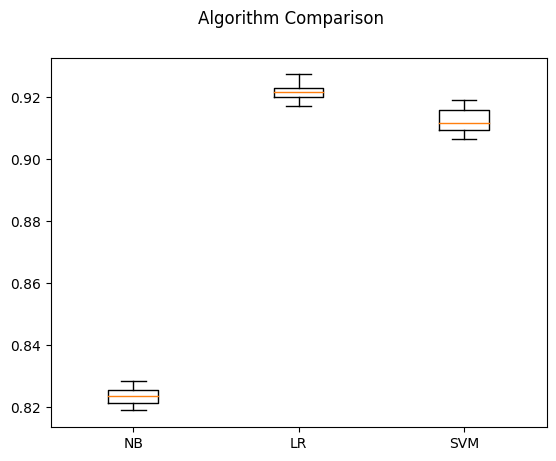

In [126]:
from sklearn import model_selection

# prepare configuration for cross validation test harness
seed = 7
# prepare models
models = []
models.append(('NB', MultinomialNB()))
models.append(('LR', LogisticRegression(max_iter=10000)))
models.append(('SVM', SGDClassifier(max_iter=100, tol=None)))

# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
	kfold = model_selection.KFold(n_splits=10, random_state=seed, shuffle=True)
	cv_results = model_selection.cross_val_score(model, X_train_dtm, y_train, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)


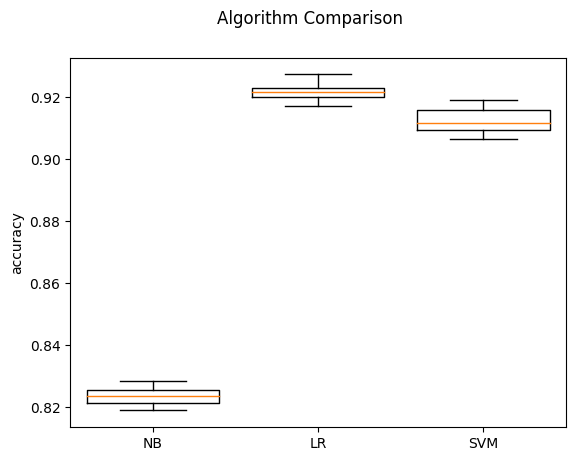

In [150]:
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results, widths=.8)
ax.set_xticklabels(names)
ax.set_ylabel('accuracy')
plt.show()

In [139]:
df[df.zip=='60077']

,inspection_id,dba_name,aka_name,license_,facility_type,risk,address,city,state,zip,inspection_date,inspection_type,results,violations,latitude,longitude,location,inspection_date_new
106087,1546475,TAQUERO FUSION,TAQUERO FUSION,2232101,Mobile Food Dispenser,Risk 3 (Low),7770 FRONTAGE RD,SKOKIE,IL,60077,2015-05-27T00:00:00.000,License,Pass,"32. FOOD AND NON-FOOD CONTACT SURFACES PROPERLY DESIGNED, CONSTRUCTED AND MAINTAINED - Comments: MUST PROVIDE PAD LOCK FOR WATER INLET FRESH WATER STORAGE TANK AND MAINTAIN.",Not Disclosed,Not Disclosed,Not Disclosed,05/27/15
154198,1098829,TAQUERO FUSION,TAQUERO FUSION,2232101,Mobile Food Dispenser,Risk 3 (Low),7770 FRONTAGE RD,SKOKIE,IL,60077,2013-02-11T00:00:00.000,License,Fail,"1. SOURCE SOUND CONDITION, NO SPOILAGE, FOODS PROPERLY LABELED, SHELLFISH TAGS IN PLACE - Comments: NO DETAILED BLUEPRINT OF COMMISSARY FACILITIES, MUST PROVIDE BLUEPRINT. ALSO PROVIDE DOCUMENTATION (PHOTOS) OF LOADING DOCK/SERVICE AREA FACILITIES SUCH AS HOSE BIBBS AND WASTE WATER DISPOSAL FACILIITES.. SUBMIT VERIFICATION THAT HOSES ARE FOOD GRADE. | 18. NO EVIDENCE OF RODENT OR INSECT OUTER OPENINGS PROTECTED/RODENT PROOFED, A WRITTEN LOG SHALL BE MAINTAINED AVAILABLE TO THE INSPECTORS - Comments: NO SCREEN FOR VENTILATION WINDOW, MUST PROVIDE, ALSO MUST KEEP SERVING WINDOW CLOSED IN BETWEEN CUSTOMERS OR ALSO PROVIDE SCREEN. | 32. FOOD AND NON-FOOD CONTACT SURFACES PROPERLY DESIGNED, CONSTRUCTED AND MAINTAINED - Comments: MUST PROVIDE VERIFICATION THAT WATER INTAKE HOSE TO FRESH WATER STORAGE TANK IS FOOD GRADE. MUST PROVIDE MANUFACTURER INFOMATION/VERIFICATION.",Not Disclosed,Not Disclosed,Not Disclosed,02/11/13


### 7. Troubleshoot

In [ ]:
X_test_df = pd.DataFrame(X_test)
X_test_df.reset_index(inplace=True, drop=True)

y_test_df = pd.DataFrame(y_test)
y_test_df.reset_index(inplace=True, drop=True)

In [ ]:
y_pred_prob = model.predict_proba(X_test_dtm)
y_pred_class = model.predict(X_test_dtm)

In [ ]:
y_pred_prob_df = pd.DataFrame(y_pred_prob)
y_pred_prob_df.columns = ['0-prob', '1-prob', '2-prob']

y_pred_class_df = pd.DataFrame(y_pred_class)
y_pred_class_df.columns = ['predicted']

In [ ]:
results_df = X_test_df.join(y_test_df).join(y_pred_class_df).join(y_pred_prob_df)

In [ ]:
results_review_df = results_df[(results_df['0-prob'] < 0.6) & (results_df['1-prob'] < 0.6) & (results_df['2-prob'] < 0.6)]
results_review_df.shape

In [ ]:
pd.set_option('display.max_colwidth', 1000)

In [ ]:
results_review_df.head(10)

# Summary
I decided to perform a multi-class classification analysis.  I narrowed my dataset to pass, fail, or pass w/ conditions due to the sufficiency of data. It appears the logistic regression had the best performance of the three models I demonstrated above. The original logisitc regression actually performed better than the one I attempted to optimize. It had a test accuracy of 92%.  The model showed slight signs of overfitting as train accuracy was 96%. Precision and recall for test were 92% for each. Precision was 96% for class 0 (pass), 87% for class 1 (fail) and 86% for class 2 (pass w/ conditions). Furthermore we know f-1 scores are the weighted averaged of precision and recall. F1 scores of 98%, 86%, and 85%, for the same classes listed previously. The model clearly is able to accuractely identify pass recommendations but struggles a little more with fail and pass with conditions, which makes sense intuitively. the F1 scores show slightly more signs of overfitting so I would attempt to adjust that in my parameter tuning. This is out of scope for this analysis, but perhaps I would do some sort of grid search or random search to approximate better parameter values.
* **Pre-processing** For text pre-processing, I decided that we needed to remove stopwords for this analysis. They are noise and do not contribute to the signal of the prediction. I also removed all the digits as again I believe they were more of a distraction. Also, within CountVectorizer, I included parameters to lowercase all words an
* **Train/Test Split** I noticed a considerable class imbalance in the dataset between the three values. I made sure to stratify my sampling in train test split to ensure the train samples and test samples resembled the population of the dataset. Another thing I considered doing but did not as it was out of scope for this analysis was training my model on an equal split data using an under-sampling or oversampling approach. This would give the model a fair chance to fully train each class equally as opposed to seeing more data of the dominate class.


<a id='end'> </a>

# Scratch

In [ ]:
df_clean[df_clean['Inspection ID']==2313093]